## Feature Scaling and Normalization - Lab

## Introduction
In this lab, you'll practice your feature scaling and normalization skills!

## Objectives
You will be able to:
* Implement min-max scaling, mean-normalization, log normalization and unit vector normalization in python
* Identify appropriate normalization and scaling techniques for given dataset

## Back to our Boston Housing data

Let's import our Boston Housing data. Remember we categorized two variables and deleted the "NOX" (nitride oxide concentration) variable because it was highly correlated with two other features.

In [42]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)

# first, create bins for based on the values observed. 5 values will result in 4 bins
bins = [0, 3, 4 , 5, 24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for based on the values observed. 5 values will result in 4 bins
bins = [0, 250, 300, 360, 460, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix="TAX")
rad_dummy = pd.get_dummies(bins_rad, prefix="RAD")
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)
boston_features = boston_features.drop("NOX",axis=1)

## Look at the histograms for the continuous variables

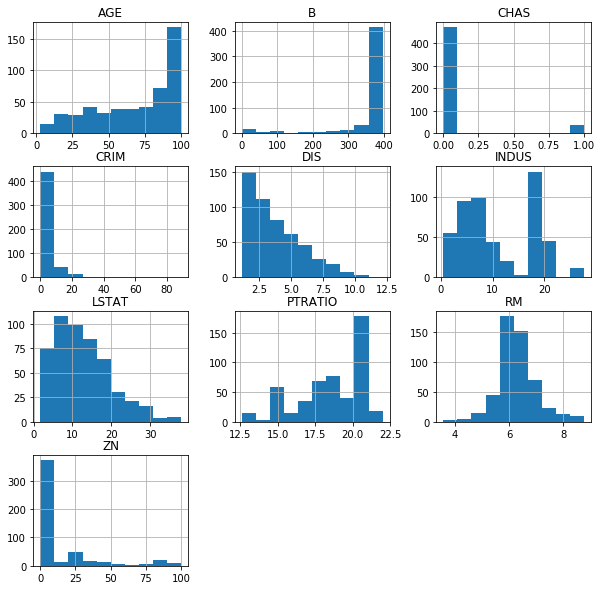

In [18]:
boston_features.iloc[:,0:10].hist(figsize=(10,10));

## Perform log transformations for the variables where it makes sense

Analyze the results in terms of how they improved the normality performance. What is the problem with the "ZN" variable?  

#### My answer
As noted below, ZN has a lot of zeros so the data is skewed. There is interesting/important data otherwise, so what could be done is to cast the data into two subsets. One in which ZN is zero, and one in which ZN is not zero. After all, it may be the case that ZN does have an impact on the median value of the home that can't be found unless a ZN greater than zero exists. For now I'll drop this data. If I had to use the data for a rigorous analysis then I would go through the trouble of parsing it out.

"ZN" has a lot of zeros (more than 50%!). Remember that this variable denoted: "proportion of residential land zoned for lots over 25,000 sq.ft.". It might have made sense to categorize this variable to "over 25,000 feet or not (binary variable 1/0). Now you have a zero-inflated variable which is cumbersome to work with.

## Try different types of transformations on the continuous variables

Store your final features in a dataframe `features_final`

### Plan
Variables that are right skewed will be log-transformed (CRIM, DIS, LSTAT, and PRATIO). In order to avoid issues with zero-valued data, half the minimum non-zero value will be added to every value. Then I'll standardize everything else not including CHAS and ZN.

In [19]:
import numpy as np

In [43]:
boston_features.head(15)

,CRIM,ZN,INDUS,CHAS,RM,AGE,DIS,PTRATIO,B,LSTAT,"RAD_(0, 3]","RAD_(3, 4]","RAD_(4, 5]","RAD_(5, 24]","TAX_(0, 250]","TAX_(250, 300]","TAX_(300, 360]","TAX_(360, 460]","TAX_(460, 712]"
0,0.00632,18.0,2.31,0.0,6.575,65.2,4.0900,15.3,396.90,4.98,1,0,0,0,0,1,0,0,0
1,0.02731,0.0,7.07,0.0,6.421,78.9,4.9671,17.8,396.90,9.14,1,0,0,0,1,0,0,0,0
2,0.02729,0.0,7.07,0.0,7.185,61.1,4.9671,17.8,392.83,4.03,1,0,0,0,1,0,0,0,0
3,0.03237,0.0,2.18,0.0,6.998,45.8,6.0622,18.7,394.63,2.94,1,0,0,0,1,0,0,0,0
4,0.06905,0.0,2.18,0.0,7.147,54.2,6.0622,18.7,396.90,5.33,1,0,0,0,1,0,0,0,0
5,0.02985,0.0,2.18,0.0,6.430,58.7,6.0622,18.7,394.12,5.21,1,0,0,0,1,0,0,0,0
6,0.08829,12.5,7.87,0.0,6.012,66.6,5.5605,15.2,395.60,12.43,0,0,1,0,0,0,1,0,0
7,0.14455,12.5,7.87,0.0,6.172,96.1,5.9505,15.2,396.90,19.15,0,0,1,0,0,0,1,0,0
8,0.21124,12.5,7.87,0.0,5.631,100.0,6.0821,15.2,386.63,29.93,0,0,1,0,0,0,1,0,0
9,0.17004,12.5,7.87,0.0,6.004,85.9,6.5921,15.2,386.71,17.10,0,0,1,0,0,0,1,0,0


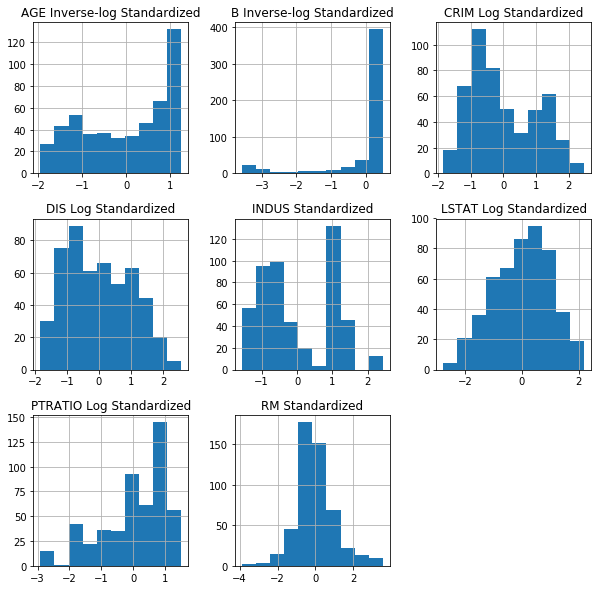

In [57]:
features_final = pd.DataFrame([])

# It'll be best to do this as a loop, since coding would mean copying and pasting. I'll also edit in place.

to_transform = ['CRIM', 'DIS', 'LSTAT', 'PTRATIO', 'AGE', 'B', 'INDUS', 'RM']
to_log = ['CRIM', 'DIS', 'LSTAT', 'PTRATIO']
to_inverse_log = ['AGE', 'B']

for feature in to_transform:
    # Log transform features in the list above
    if feature in to_log:
        min_non_zero = np.min(boston_features.loc[boston_features[feature] > 0][feature])
        feature_data = np.log(boston_features[feature]+min_non_zero/2)
        label = ' Log Standardized'
    elif feature in to_inverse_log:
        # Normalize first
        normalized_data = (boston_features[feature]-np.min(boston_features[feature]))/(
                            np.max(boston_features[feature])-np.min(boston_features[feature]))
        feature_data = np.exp(normalized_data)
        label = ' Inverse-log Standardized'
    else:
        feature_data = boston_features[feature]
        label = ' Standardized'
    # Now standardize the features
    standardized_feature = (feature_data - np.mean(feature_data))/(np.std(feature_data))
    
    features_final[feature+label] = standardized_feature

features_final.hist(figsize = (10,10));

## Summary
Great! You've now transformed your final data using feature scaling and normalization, and stored them in the `features_final` dataframe.